# Classification algorithm


## 1.0 Introduction
This is the notebook to create a classfication algorithm for the masters thesis. It will start by creating a data-frame so we can test on a small scale how the end product should work. We then compile the network architecture and train with the dataset. The algorithm is then evaluated on the validation data-set and later on a test set. The test set is unlabeled and the findings will be inserted to the data-frame mentioned before. For more indepth explanation and analysis of the algorithm please consult the thesis.



### 1.1 Import libraries
The following was performed with:
*  Tensorflow 2.9.1
*  Numpy 1.22.4
*  Pandas 1.4.2
*  CV2 4.6.9
*  Make sure to install the latest pip versions when trying to upgrade the packages on your local machine.

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 6.8 MB/s 


In [ ]:
#Necessary libraries
import pandas as pd
import os
from google.colab import files

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17534350445615029830
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8805389665126279236
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

### 1.2 Connect to your google drive if data is there

In [ ]:
#connect to my google drive
#%cd ..
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### 1.3 Creating a Dataframe where all the output will go into it

In [ ]:
from google.colab import files
files.upload()

In [ ]:
#import pandas as pd
#df=pd.read_csv('HighResolution_Positions.csv',index_col='Filename') #Use this if you used the upload function
df=pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/HighResolution_Positions.csv',index_col='Filename') #Use this if csv is your drive

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40591 entries, HighRes_10541 to HighRes_10540
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SurveyName  40591 non-null  int64  
 1   ORIG_Name   40591 non-null  object 
 2   cameraLon   40591 non-null  float64
 3   cameraLat   40591 non-null  float64
 4   cameraAlt   40591 non-null  float64
 5   cameraX     40591 non-null  float64
 6   cameraY     40591 non-null  float64
 7   cameraZ     40591 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.8+ MB


In [ ]:
#Drop unnecessary columns 
df.drop(['SurveyName', 'ORIG_Name','cameraX','cameraY','cameraZ'], axis=1, inplace=True)
#Create a subframe based on the 

In [ ]:
#Will add column names that we need
df=df.reindex(columns=df.columns.to_list()+['Material','Metal sheet','Rust grade','Reference object','Height'])

In [ ]:
df

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust grade,Reference object,Height
Filename,,,,,,,,
HighRes_10541,6.216486,53.237703,0.35,NaN,NaN,NaN,NaN,NaN
HighRes_10542,6.216483,53.237703,0.25,NaN,NaN,NaN,NaN,NaN
HighRes_10543,6.216485,53.237704,0.20,NaN,NaN,NaN,NaN,NaN
HighRes_10544,6.218342,53.237293,-3.46,NaN,NaN,NaN,NaN,NaN
HighRes_10545,6.218486,53.237307,-3.57,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
HighRes_10536,6.225120,53.238759,0.42,NaN,NaN,NaN,NaN,NaN
HighRes_10537,6.225196,53.238789,0.39,NaN,NaN,NaN,NaN,NaN
HighRes_10538,6.225256,53.238827,0.33,NaN,NaN,NaN,NaN,NaN


## 2.0 Model architecture

### 2.1 Create model

In [ ]:
#Piece of code for data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.1)
    ]
)

#VGG16 like block
def VGG16_Like(x,filters,pooling=False):
  x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding="same")(x)
  if pooling:
    x = layers.MaxPooling2D(2, padding="same")(x)
  return x

#Residual connection block
def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:     
      x = layers.MaxPooling2D(2, padding="same")(x)
      residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
      residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

#inception like block
def Inception_Like(x,filters,pooling=False):
  residual=x
  x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding="same")(x)
  residual=layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding="same")(residual)
  if pooling:
    x = layers.MaxPooling2D(2, padding="same")(x)
    residual = layers.Conv2D(filters, 1, strides=2)(residual)
  elif filters != residual.shape[-1]:
    residual = layers.Conv2D(filters, 1)(residual) 
  x = layers.add([x, residual])
  return x

In [ ]:
#start model for making one model
inputs = keras.Input(shape=(400, 400, 3))             #Input layer, set the shape
#x = data_augmentation(inputs)                         #Augment layer as part of the NN
x = layers.Rescaling(1./255)(inputs)                       #Scale layers so values are between 0 and 1

#Blocks
x=Inception_Like(x,filters=32, pooling=True)
x=Inception_Like(x,filters=32, pooling=True)
x=Inception_Like(x,filters=32, pooling=True)
x=Inception_Like(x,filters=32, pooling=True)
#x=Inception_Like(x,filters=32, pooling=True)
x=Inception_Like(x,filters=32, pooling=False)            #Last block no pooling

x = layers.GlobalAveragePooling2D()(x)                #last blocks has no pooling, so global pool
outputs = layers.Dense(6, activation="softmax")(x)    #The output layer
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Model+ residual blocks
def make_wB_model(amount_classes):
  #Piece of code for data augmentation
  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
          layers.RandomContrast(0.1)
      ]
  )
  #start of input
  inputs = keras.Input(shape=(400, 400, 3))
  #x = data_augmentation(inputs)
  x = layers.Rescaling(1./255)(inputs)

  #using residual block function
  x = residual_block(x, filters=32, pooling=True)
  x = residual_block(x, filters=32, pooling=True)
  x = residual_block(x, filters=32, pooling=True)
  x = residual_block(x, filters=32, pooling=True)
  #x = residual_block(x, filters=256, pooling=True)
  x = residual_block(x, filters=32, pooling=False)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(amount_classes, activation="softmax")(x)#Change the amount of units according to the amount of classses
  return keras.Model(inputs=inputs, outputs=outputs)

#model=make_wB_model(6)

In [ ]:
model.compile(
              optimizer=keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #put logits false later
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

### 2.2 preprocess training data
#### 2.2.1 Using the upload function (Optional)
Skip this part, if all the training data is in your google drive

In [ ]:
files.upload()

Saving 03-Foto.zip to 03-Foto.zip


In [ ]:
!unzip -qq 03-Foto.zip -d Train_data #change name

#### 2.2.2 In cloud.
Important parameters:
*   ***The path to data***. Change the path.
*   ***Seed***. In case you want to change the shuffle.
*   ***Validation split***. The ratio between train/validation is now 70%/30%. You can call this the Test set too if you desire and then split again when training the model in ch 2.3.



In [ ]:
#from sklearn.utils import shuffle
#Using the function to load images
train_dataset = image_dataset_from_directory("/content/gdrive/MyDrive/ColabNotebooks/TRAIN",
    image_size=(400, 400),
    validation_split=0.3,
    subset="training",
    seed=2,
    #shuffle=False,
    batch_size=32)
validation_dataset = image_dataset_from_directory("/content/gdrive/MyDrive/ColabNotebooks/TRAIN",
    image_size=(400, 400),
    validation_split=0.3,
    subset="validation",
    seed=2,
    #shuffle=False,
    batch_size=32)#1801
#test_dataset = image_dataset_from_directory(
#    new_base_dir / "test",
#    image_size=(180, 180),
#    batch_size=32)

Found 1801 files belonging to 6 classes.
Using 1261 files for training.
Found 1801 files belonging to 6 classes.
Using 540 files for validation.


In [ ]:
#Uncomment if you want to apply augmentation on the dataset, instead of using an augment layer in the CNN
#train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
#validation_dataset=validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
#Optimize dataset for performance
train_dataset = train_dataset.prefetch(buffer_size=32)
validation_dataset = validation_dataset.prefetch(buffer_size=32)

In [ ]:
#Check the order of the class names
train_dataset.class_names

['Grass',
 'Metal_Acceptable',
 'Metal_Bad',
 'Metal_Good',
 'Metal_Moderate',
 'Rock']

### 2.3 Train the model
Important parameters:

*   ***The file path***. Set the path to where the model is saved. Also create an appropriate name.
*   ***Epoch***. Depending on the amount of classes you might need to increase if you add more classes. Or lower incase less classes



#### 2.3.1 Train for one model

In [ ]:
#For 1 model /content/gdrive/MyDrive/ColabNotebooks/Models/
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="W+B_CNN_6c_inception_5b_noaugm_filt32_run0.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50, #variatie
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
40/40 [==============================] - 737s 15s/step - loss: 1.7775 - accuracy: 0.1792 - val_loss: 1.7574 - val_accuracy: 0.1926
Epoch 2/50
40/40 [==============================] - 26s 581ms/step - loss: 1.7553 - accuracy: 0.2038 - val_loss: 1.7457 - val_accuracy: 0.1907
Epoch 3/50
40/40 [==============================] - 27s 613ms/step - loss: 1.7192 - accuracy: 0.2601 - val_loss: 1.6812 - val_accuracy: 0.3000
Epoch 4/50
40/40 [==============================] - 26s 576ms/step - loss: 1.3914 - accuracy: 0.3981 - val_loss: 1.1155 - val_accuracy: 0.4852
Epoch 5/50
40/40 [==============================] - 26s 584ms/step - loss: 1.2359 - accuracy: 0.4417 - val_loss: 1.2856 - val_accuracy: 0.4056
Epoch 6/50
40/40 [==============================] - 28s 624ms/step - loss: 1.1617 - accuracy: 0.4639 - val_loss: 1.0506 - val_accuracy: 0.5296
Epoch 7/50
40/40 [==============================] - 26s 579ms/step - loss: 1.0808 - accuracy: 0.4964 - val_loss: 1.3423 - val_accuracy: 0.4722


#### 2.3.2 Train for cross validation
The cross validation is based on using different seeds when shuffling the data. There is one important parameter when

Found 2534 files belonging to 4 classes.
Using 1774 files for training.
Found 2534 files belonging to 4 classes.
Using 760 files for validation.
Epoch 1/30
56/56 [==============================] - 1034s 16s/step - loss: 1.3320 - accuracy: 0.3185 - val_loss: 1.1416 - val_accuracy: 0.4171
Epoch 2/30
56/56 [==============================] - 35s 569ms/step - loss: 1.1912 - accuracy: 0.3918 - val_loss: 1.1617 - val_accuracy: 0.4803
Epoch 3/30
56/56 [==============================] - 35s 540ms/step - loss: 1.0831 - accuracy: 0.4583 - val_loss: 0.9113 - val_accuracy: 0.5158
Epoch 4/30
56/56 [==============================] - 32s 535ms/step - loss: 0.9270 - accuracy: 0.5271 - val_loss: 0.8936 - val_accuracy: 0.5461
Epoch 5/30
56/56 [==============================] - 33s 536ms/step - loss: 0.8494 - accuracy: 0.5586 - val_loss: 0.8062 - val_accuracy: 0.5776
Epoch 6/30
56/56 [==============================] - 33s 538ms/step - loss: 0.8046 - accuracy: 0.5891 - val_loss: 0.6583 - val_accuracy: 0.68

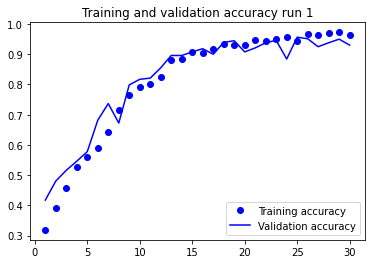

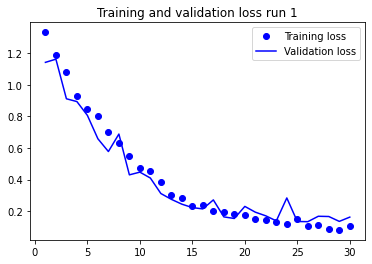

Found 2534 files belonging to 4 classes.
Using 1774 files for training.
Found 2534 files belonging to 4 classes.
Using 760 files for validation.
Epoch 1/30
56/56 [==============================] - 215s 4s/step - loss: 1.3938 - accuracy: 0.2723 - val_loss: 1.3983 - val_accuracy: 0.2355
Epoch 2/30
56/56 [==============================] - 32s 533ms/step - loss: 1.1746 - accuracy: 0.4047 - val_loss: 1.0582 - val_accuracy: 0.4211
Epoch 3/30
56/56 [==============================] - 34s 548ms/step - loss: 0.9761 - accuracy: 0.4927 - val_loss: 0.9274 - val_accuracy: 0.4961
Epoch 4/30
56/56 [==============================] - 32s 535ms/step - loss: 0.8632 - accuracy: 0.5643 - val_loss: 0.8721 - val_accuracy: 0.5566
Epoch 5/30
56/56 [==============================] - 32s 536ms/step - loss: 0.8420 - accuracy: 0.5953 - val_loss: 1.0042 - val_accuracy: 0.5329
Epoch 6/30
56/56 [==============================] - 32s 533ms/step - loss: 0.7363 - accuracy: 0.6550 - val_loss: 0.7202 - val_accuracy: 0.6658

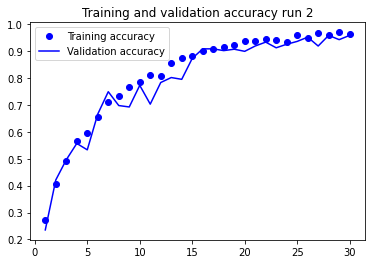

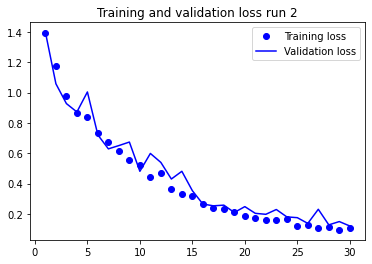

In [ ]:
#For cros val
for seeds in [1,2]:
  model=make_wB_model(6) #important parameter
  model.compile(
              optimizer=keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #put logits false later
              metrics=["accuracy"])
  train_dataset = image_dataset_from_directory("/content/gdrive/MyDrive/ColabNotebooks/TRAIN4C",
    image_size=(400, 400),
    validation_split=0.3,
    subset="training",
    seed=seeds,
    batch_size=32)
  validation_dataset = image_dataset_from_directory("/content/gdrive/MyDrive/ColabNotebooks/TRAIN4C",
    image_size=(400, 400),
    validation_split=0.3,
    subset="validation",
    seed=seeds,
    batch_size=32)
  
  #optimize for performance
  train_dataset = train_dataset.prefetch(buffer_size=32)
  validation_dataset = validation_dataset.prefetch(buffer_size=32)
  callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"W+B_CNN_ep30_6c_resblok_noaugm_filt32_run{seeds}.keras",
        save_best_only=True,
        monitor="val_loss")]

  history = model.fit(
      train_dataset,
      epochs=30, #variatie
      validation_data=validation_dataset,callbacks=callbacks)
  
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
  plt.title(f"Training and validation accuracy run {seeds}")
  plt.legend()
  plt.savefig(f'Training and validation accuracy run {seeds}.png')
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title(f"Training and validation loss run {seeds}")
  plt.legend()
  plt.savefig(f'Training and validation loss run {seeds}.png')
  plt.show()


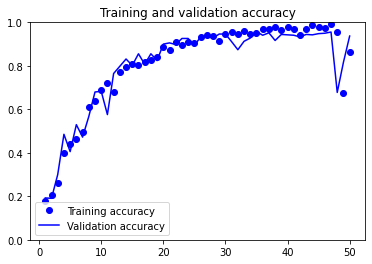

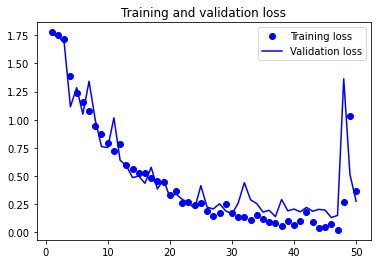

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.ylim(0,1)
plt.title("Training and validation accuracy")
plt.savefig('Training and validation accuracy 4 resbl.png')
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig('Training and validation loss 4 resbl.png')
plt.show()

### Keras tuner
Will need this for hyperparameter tuning

*   https://keras.io/keras_tuner/
*   https://keras.io/guides/keras_tuner/getting_started



### 2.4 Load model
only use this if already compiled and saved the model

In [ ]:
files.upload()

Saving W+B_CNN_ep30+Aug+Rescon.keras to W+B_CNN_ep30+Aug+Rescon.keras


In [ ]:

model = keras.models.load_model("/content/gdrive/MyDrive/ColabNotebooks/Models/W+B_CNN_ep50_6c_resblok_6b_augm_32-256_run2.keras")#/content/W+B_CNN_ep30+Aug+Rescon.keras
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_4 (Sequential)      (None, 400, 400, 3)  0           ['input_3[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 400, 400, 3)  0           ['sequential_4[0][0]']           
                                                                                                  
 conv2d_34 (Conv2D)             (None, 400, 400, 32  896         ['rescaling_2[0][0]']      

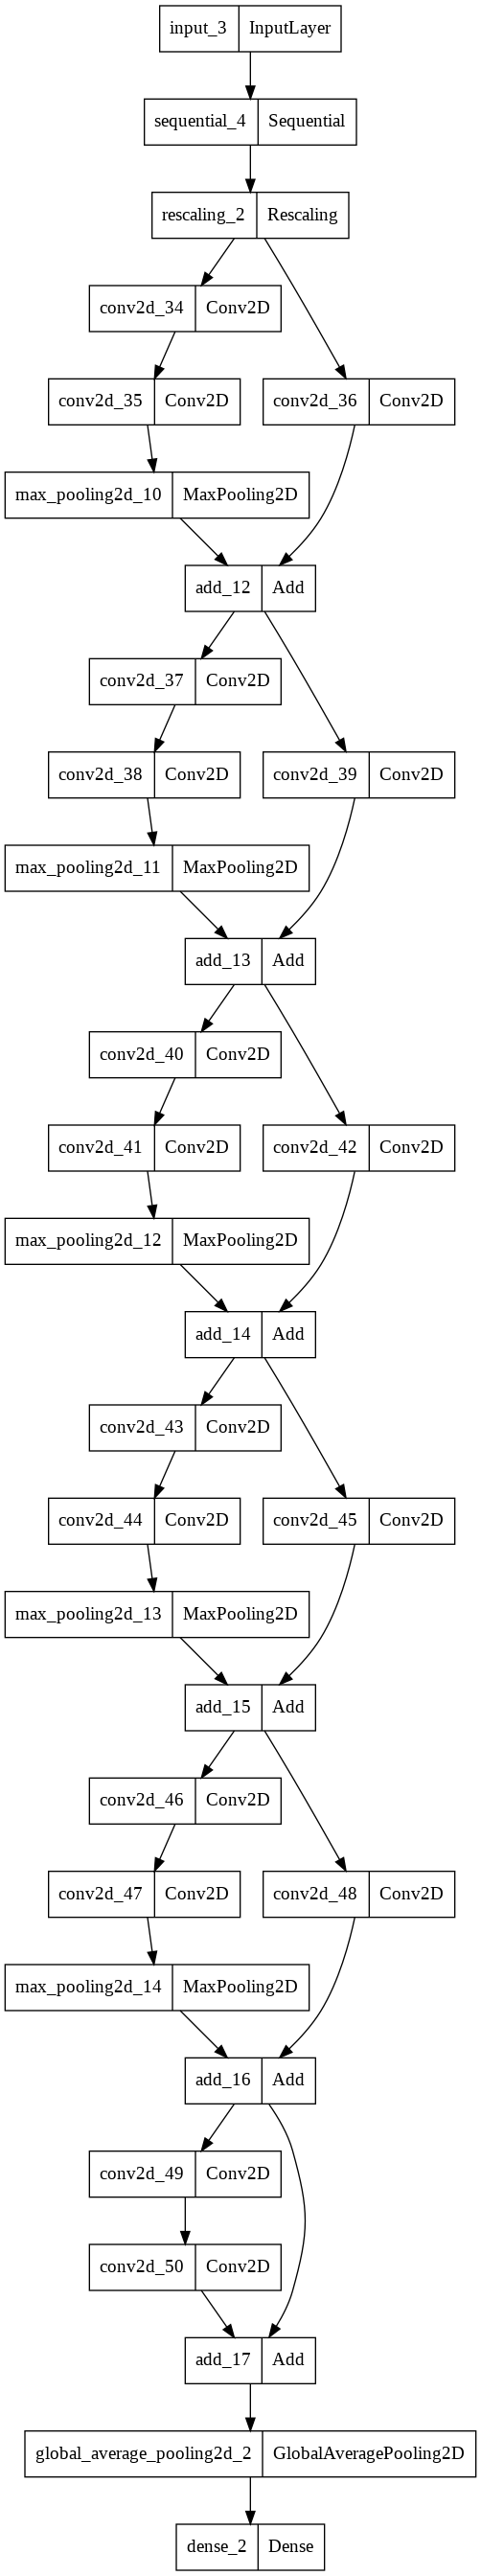

In [ ]:
keras.utils.plot_model(model)
#visualkeras.layered_view(model)

In [ ]:
model.evaluate(validation_dataset)

### 2.5 confusion metrics

In [ ]:
#important libraries/modules
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#check if needed
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score #use when
import numpy as np

In [ ]:
#Function to plot confusion matrixes
def Make_Heatmap(matrix,classes,title=str):
  ax = sns.heatmap(matrix, annot=True, cmap='Blues')

  ax.set_title(f'Confusion Matrix for {title} with labels\n\n');
  ax.set_xlabel(f'\nPredicted {title} Category')
  ax.set_ylabel(f'Actual {title} Category ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'C5_confusionM_{title}.png',bbox_inches="tight")

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [ ]:
def class_label(score_im):
  #switch={
  #    0:('Grass',np.nan),
  #    1:('Metal','bad'),
  #    2:('Metal','good'),
  #    3:('Rock',np.nan)}
  switch={0:('Grass','Grass'),
          1:('Metal','M-acceptable'),
          2:('Metal','M-bad'),
          3:('Metal','M-good'),
          4:('Metal','M-moderate'),
          5:('Rock','Rock')}
  return switch.get(score_im)

In [ ]:
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
x_val = np.concatenate([x for x, y in validation_dataset], axis=0)


In [ ]:
y_true

array([3, 4, 1, 5, 2, 0, 1, 2, 5, 5, 1, 2, 3, 4, 5, 4, 0, 0, 0, 5, 4, 2,
       1, 4, 3, 4, 3, 1, 3, 2, 3, 5, 1, 2, 0, 3, 0, 0, 2, 2, 0, 4, 3, 0,
       5, 4, 5, 4, 5, 2, 1, 3, 5, 0, 5, 0, 3, 1, 0, 0, 5, 4, 4, 1, 0, 4,
       1, 0, 4, 2, 3, 5, 0, 4, 0, 4, 4, 2, 0, 5, 1, 5, 1, 3, 3, 0, 4, 0,
       4, 0, 4, 4, 3, 0, 0, 1, 4, 2, 3, 4, 2, 1, 3, 5, 0, 2, 2, 1, 2, 5,
       0, 3, 5, 4, 5, 5, 5, 1, 4, 2, 5, 5, 4, 5, 5, 0, 3, 4, 1, 0, 3, 3,
       1, 4, 4, 0, 5, 3, 0, 3, 0, 1, 4, 3, 4, 1, 1, 5, 0, 1, 2, 0, 0, 3,
       3, 5, 3, 1, 2, 3, 4, 3, 4, 5, 3, 0, 2, 4, 4, 1, 3, 3, 5, 3, 3, 3,
       0, 3, 4, 4, 4, 4, 5, 0, 1, 3, 0, 5, 0, 0, 5, 3, 1, 4, 3, 2, 4, 0,
       3, 4, 3, 3, 3, 5, 0, 2, 0, 2, 3, 4, 0, 5, 4, 3, 0, 1, 5, 0, 3, 0,
       0, 0, 0, 1, 4, 0, 5, 2, 2, 1, 3, 4, 5, 0, 5, 1, 1, 1, 2, 3, 4, 4,
       5, 4, 5, 3, 0, 0, 5, 4, 0, 0, 0, 5, 1, 0, 0, 5, 3, 1, 1, 4, 3, 3,
       3, 1, 3, 5, 2, 2, 3, 2, 5, 1, 0, 1, 4, 1, 5, 2, 3, 5, 4, 3, 5, 2,
       0, 5, 1, 4, 5, 5, 5, 1, 3, 5, 4, 5, 4, 0, 3,

In [ ]:
y_pred = model.predict(x_val)

In [ ]:
y_pred2=[x.argsort()[-1] for x in y_pred]

In [ ]:
len(y_pred2)

540

In [ ]:
#y_pred = model.predict(validation_dataset).argmax(axis=1)
cm = confusion_matrix(y_true, y_pred2)

In [ ]:
cm

array([[14, 21,  7, 21, 15, 20],
       [ 9, 17, 11, 22, 15, 13],
       [14, 12,  4, 10,  6,  8],
       [25, 18, 16, 19, 11, 25],
       [14, 14,  6, 19, 21, 17],
       [20, 17,  9, 16, 17, 17]])

In [ ]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation accuracy: {val_acc:.3f}")

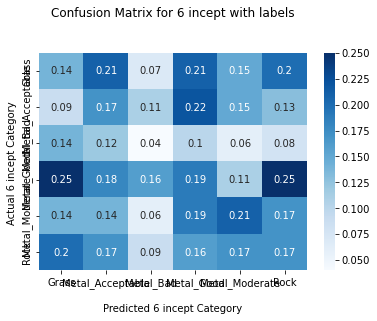

              precision    recall  f1-score   support

           0       0.15      0.14      0.14        98
           1       0.17      0.20      0.18        87
           2       0.08      0.07      0.07        54
           3       0.18      0.17      0.17       114
           4       0.25      0.23      0.24        91
           5       0.17      0.18      0.17        96

    accuracy                           0.17       540
   macro avg       0.16      0.16      0.16       540
weighted avg       0.17      0.17      0.17       540



In [ ]:
Make_Heatmap(cm/100,validation_dataset.class_names,'6 incept')
print(classification_report(y_true, y_pred2))

In [ ]:
validation_dataset = image_dataset_from_directory(Path_to_images,
    image_size=(400, 400),
    validation_split=0.3,
    subset="validation",
    seed=2,
    batch_size=1801)

model=keras.models.load_model(Path_to_model)

#first method to get accuracy
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation accuracy: {val_acc:.3f}") #prints acc 93%

#second method to get accuracy also to get confusion matrix
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset).argmax(axis=1)
print(classification_report(y_true, y_pred)) #prints acc 17%

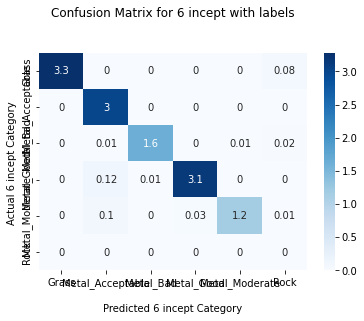

In [ ]:
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
#x_val = np.concatenate([x for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
#plot_confusion_matrix(cm, list(range(4)))
Make_Heatmap(cm/100,validation_dataset.class_names,'6 incept')

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       336
           1       0.93      1.00      0.96       300
           2       0.99      0.98      0.98       167
           3       0.99      0.96      0.98       327
           4       0.99      0.89      0.94       131
           5       0.00      0.00      0.00         0

    accuracy                           0.97      1261
   macro avg       0.82      0.80      0.81      1261
weighted avg       0.98      0.97      0.97      1261



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.0 Test data-set
upload test files straight to this session or to whatever path they are.

In [ ]:
files.upload()

Saving Test.zip to Test.zip


In [ ]:
!unzip -qq Test.zip

### 3.1 Load the test data-set

In [ ]:
#import os
# Get the list of all files and directories in the test folder
#path = "/content/Test"
path = "/content/gdrive/MyDrive/ColabNotebooks/TEST"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")
 


Files and directories in ' /content/gdrive/MyDrive/ColabNotebooks/TEST ' :


In [ ]:
names=[]
for name in dir_list:
  names.append(name.split('.')[0]) #split the filename where '.' is located

In [ ]:
test_dataset = image_dataset_from_directory(path,
    labels=None, #Test data have no label as we want to predict them
    image_size=(400, 400),
    batch_size=32)

Found 40 files belonging to 1 classes.


In [ ]:
names

['HighRes_10556',
 'HighRes_10557',
 'HighRes_10563',
 'HighRes_10564',
 'HighRes_10571',
 'HighRes_10572',
 'HighRes_10575',
 'HighRes_10576',
 'HighRes_10577',
 'HighRes_10601',
 'HighRes_10602',
 'HighRes_25996',
 'HighRes_25997',
 'HighRes_25998',
 'HighRes_25999',
 'HighRes_26000',
 'HighRes_26049',
 'HighRes_26050',
 'HighRes_26051',
 'HighRes_01386',
 'HighRes_01387',
 'HighRes_01388',
 'HighRes_01389',
 'HighRes_01390']

In [ ]:
df2=df.loc[names]

In [ ]:
df2

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust grade,Reference object,Height
Filename,,,,,,,,
HighRes_10556,6.220051,53.237499,-4.16,NaN,NaN,NaN,NaN,NaN
HighRes_10557,6.220186,53.237506,-4.18,NaN,NaN,NaN,NaN,NaN
HighRes_10563,6.220930,53.237596,-4.23,NaN,NaN,NaN,NaN,NaN
HighRes_10564,6.221048,53.237616,-4.21,NaN,NaN,NaN,NaN,NaN
HighRes_10571,6.221783,53.237778,-4.07,NaN,NaN,NaN,NaN,NaN
HighRes_10572,6.221890,53.237805,-4.03,NaN,NaN,NaN,NaN,NaN
HighRes_10575,6.222209,53.237891,-3.91,NaN,NaN,NaN,NaN,NaN
HighRes_10576,6.222318,53.237918,-3.88,NaN,NaN,NaN,NaN,NaN
HighRes_10577,6.222429,53.237946,-3.84,NaN,NaN,NaN,NaN,NaN


In [ ]:
img = keras.preprocessing.image.load_img(f"/content/Test/HighRes_01386.jpg", target_size=(180,180)) #change path if different folder

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array) #will predict the class of the image
score = predictions[0]

In [ ]:
#Check the class names and in which order they are
train_dataset.class_names

['Grass', 'Metal_Bad', 'Metal_Good', 'Rock']

In [ ]:
#Check the class names and in which order they are
train_dataset.class_names

['Grass',
 'Metal_Acceptable',
 'Metal_Bad',
 'Metal_Good',
 'Metal_Moderate',
 'Rock']

### 3.2 Forward pass on the test data-set
A rather crude way this code was written. Please check the inference notebook for a "clean" version



In [ ]:
def class_label(score_im):
  #switch={
  #    0:('Grass',np.nan),
  #    1:('Metal','bad'),
  #    2:('Metal','good'),
  #    3:('Rock',np.nan)}
  switch={0:('Grass','Grass'),
          1:('Metal','M-acceptable'),
          2:('Metal','M-bad'),
          3:('Metal','M-good'),
          4:('Metal','M-moderate'),
          5:('Rock','Rock')}
  return switch.get(score_im)

In [ ]:
import numpy as np

In [ ]:
for name in names:
  img = keras.preprocessing.image.load_img(
    f"{path}/{name}.jpg", target_size=(400,400))        #Change path and ratio if different folder
  

  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)                # Create batch axis

  predictions = model.predict(img_array)                  #will predict the class of the image
  index_scores=np.argsort(predictions[0])                 #value with max index is at the end
  class_lab=class_label(index_scores[-1])                 #gives tuple with (material, grade), in case not metal then grade=nan

  df2.loc[f'{name}','Material']=class_lab[0]              #insert relevant data into dataframe
  df2.loc[f'{name}','Rust grade']=class_lab[1]

In [ ]:
df2.sort_values(by=['Filename'], inplace=True)
df2 #epoch30+aug +drop+res 26 may

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust grade,Reference object,Height
Filename,,,,,,,,
HighRes_01386,5.692051,52.968265,-1.51,Grass,NaN,Grass,NaN,NaN
HighRes_01387,5.692022,52.968320,-1.51,Grass,NaN,Grass,NaN,NaN
HighRes_01388,5.691991,52.968376,-1.51,Grass,NaN,Grass,NaN,NaN
HighRes_01389,5.691958,52.968430,-1.52,Grass,NaN,Grass,NaN,NaN
HighRes_01390,5.691923,52.968484,-1.54,Grass,NaN,Grass,NaN,NaN
HighRes_01605,5.690281,52.975704,-0.92,Grass,NaN,Grass,NaN,NaN
HighRes_01606,5.690255,52.975772,-0.92,Grass,NaN,Grass,NaN,NaN
HighRes_01735,5.688134,52.983188,-0.38,Rock,NaN,Rock,NaN,NaN
HighRes_01736,5.688145,52.983254,-0.34,Rock,NaN,Rock,NaN,NaN


In [ ]:
df2.sort_values(by=['Filename'], inplace=True)
df2 #epoch30+aug +drop+res16 may

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust grade,Reference object,Height
Filename,,,,,,,,
HighRes_01386,5.692051,52.968265,-1.51,Grass,NaN,NaN,NaN,NaN
HighRes_01387,5.692022,52.968320,-1.51,Rock,NaN,NaN,NaN,NaN
HighRes_01388,5.691991,52.968376,-1.51,Grass,NaN,NaN,NaN,NaN
HighRes_01389,5.691958,52.968430,-1.52,Grass,NaN,NaN,NaN,NaN
HighRes_01390,5.691923,52.968484,-1.54,Grass,NaN,NaN,NaN,NaN
HighRes_01605,5.690281,52.975704,-0.92,Grass,NaN,NaN,NaN,NaN
HighRes_01606,5.690255,52.975772,-0.92,Grass,NaN,NaN,NaN,NaN
HighRes_01735,5.688134,52.983188,-0.38,Rock,NaN,NaN,NaN,NaN
HighRes_01736,5.688145,52.983254,-0.34,Rock,NaN,NaN,NaN,NaN


In [ ]:
df2.sort_values(by=['Filename'], inplace=True)
df2 #epoch30+aug +drop+res

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust size/grade,Reference object,Height
Filename,,,,,,,,
HighRes_01386,5.692051,52.968265,-1.51,Grass,NaN,NaN,NaN,NaN
HighRes_01387,5.692022,52.968320,-1.51,Grass,NaN,NaN,NaN,NaN
HighRes_01388,5.691991,52.968376,-1.51,Grass,NaN,NaN,NaN,NaN
HighRes_01389,5.691958,52.968430,-1.52,Grass,NaN,NaN,NaN,NaN
HighRes_01390,5.691923,52.968484,-1.54,Grass,NaN,NaN,NaN,NaN
HighRes_10556,6.220051,53.237499,-4.16,Rock,NaN,NaN,NaN,NaN
HighRes_10557,6.220186,53.237506,-4.18,Rock,NaN,NaN,NaN,NaN
HighRes_10563,6.220930,53.237596,-4.23,Rock,NaN,NaN,NaN,NaN
HighRes_10564,6.221048,53.237616,-4.21,Rock,NaN,NaN,NaN,NaN


In [ ]:
df2.sort_values(by=['Filename'], inplace=True)
df2 #epoch40 +drop

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust size/grade,Reference object,Height
Filename,,,,,,,,
HighRes_01386,5.692051,52.968265,-1.51,Grass,NaN,NaN,NaN,NaN
HighRes_01387,5.692022,52.968320,-1.51,Rock,NaN,NaN,NaN,NaN
HighRes_01388,5.691991,52.968376,-1.51,Grass,NaN,NaN,NaN,NaN
HighRes_01389,5.691958,52.968430,-1.52,Grass,NaN,NaN,NaN,NaN
HighRes_01390,5.691923,52.968484,-1.54,Grass,NaN,NaN,NaN,NaN
HighRes_10556,6.220051,53.237499,-4.16,Metal,NaN,NaN,NaN,NaN
HighRes_10557,6.220186,53.237506,-4.18,Metal,NaN,NaN,NaN,NaN
HighRes_10563,6.220930,53.237596,-4.23,Rock,NaN,NaN,NaN,NaN
HighRes_10564,6.221048,53.237616,-4.21,Rock,NaN,NaN,NaN,NaN


In [ ]:
df2#epoch 30 no drop

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust size/grade,Reference object,Height
Filename,,,,,,,,
HighRes_10577,6.222429,53.237946,-3.84,Grass,NaN,NaN,NaN,NaN
HighRes_10576,6.222318,53.237918,-3.88,Grass,NaN,NaN,NaN,NaN
HighRes_01389,5.691958,52.968430,-1.52,Grass,NaN,NaN,NaN,NaN
HighRes_10575,6.222209,53.237891,-3.91,Grass,NaN,NaN,NaN,NaN
HighRes_26051,6.599841,53.223536,-0.20,Grass,NaN,NaN,NaN,NaN
HighRes_25997,6.633236,53.232200,2.90,Metal,NaN,NaN,NaN,NaN
HighRes_26000,6.632938,53.232111,2.90,Grass,NaN,NaN,NaN,NaN
HighRes_10556,6.220051,53.237499,-4.16,Grass,NaN,NaN,NaN,NaN
HighRes_01386,5.692051,52.968265,-1.51,Grass,NaN,NaN,NaN,NaN


In [ ]:
df2 #epoch 30+drop

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust size/grade,Reference object,Height
Filename,,,,,,,,
HighRes_10577,6.222429,53.237946,-3.84,Rock,NaN,NaN,NaN,NaN
HighRes_10576,6.222318,53.237918,-3.88,Rock,NaN,NaN,NaN,NaN
HighRes_01389,5.691958,52.968430,-1.52,Grass,NaN,NaN,NaN,NaN
HighRes_10575,6.222209,53.237891,-3.91,Rock,NaN,NaN,NaN,NaN
HighRes_26051,6.599841,53.223536,-0.20,Rock,NaN,NaN,NaN,NaN
HighRes_25997,6.633236,53.232200,2.90,Rock,NaN,NaN,NaN,NaN
HighRes_26000,6.632938,53.232111,2.90,Rock,NaN,NaN,NaN,NaN
HighRes_10556,6.220051,53.237499,-4.16,Rock,NaN,NaN,NaN,NaN
HighRes_01386,5.692051,52.968265,-1.51,Grass,NaN,NaN,NaN,NaN


In [ ]:
df2.sort_values(by=['Filename'], inplace=True)

,cameraLon,cameraLat,cameraAlt,Material,Metal sheet,Rust size/grade,Reference object
Filename,,,,,,,
HighRes_01386,5.692051,52.968265,-1.51,Grass,NaN,NaN,NaN
HighRes_01387,5.692022,52.968320,-1.51,Grass,NaN,NaN,NaN
HighRes_01388,5.691991,52.968376,-1.51,Grass,NaN,NaN,NaN
HighRes_01389,5.691958,52.968430,-1.52,Grass,NaN,NaN,NaN
HighRes_01390,5.691923,52.968484,-1.54,Grass,NaN,NaN,NaN
HighRes_10556,6.220051,53.237499,-4.16,Rock,NaN,NaN,NaN
HighRes_10557,6.220186,53.237506,-4.18,Grass,NaN,NaN,NaN
HighRes_10563,6.220930,53.237596,-4.23,Rock,NaN,NaN,NaN
HighRes_10564,6.221048,53.237616,-4.21,Grass,NaN,NaN,NaN


In [ ]:
df2.to_csv('/content/newdata.csv')

# End of Codes

In [ ]:
#For some reason this does not yield the same model, don't use
def Type_block(x,Type,filter,pool):
  switch={'vgg16':VGG16_Like(x,filter,pool),
          'rescon':residual_block(x,filter,pool),
          'inception':Inception_Like(x,filter,pool),
          }
  return switch.get(Type)

def make_wB_model(amount_classes,blocks,Type='vgg16',augment='No_augm',filter_style='not_increase'):
  
  if filter_style=='increase':              #If filter is increasing or not
    filt=[32,64,128,256,256,256,256]
  else:
    filt=[32,32,32,32,32,32,32]
  
  #start of input
  inputs = keras.Input(shape=(400, 400, 3))
  if augment=='True':                       #check if augment is needed
    x = data_augmentation(inputs)
    
  else:
    x = layers.Rescaling(1./255)(inputs)

  for block in range(blocks-1):             #Create blocks
    x=Type_block(x,Type,filter=filt[block],pool=False)
  x=Type_block(x,Type,filter=filt[blocks],pool=True)
  
  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(amount_classes, activation="softmax")(x)#Change the amount of units according to the amount of classses
  return keras.Model(inputs=inputs, outputs=outputs)

model=make_wB_model(4,5,'rescon','No-augm','increase')
model.summary()

,cameraLon,cameraLat,cameraAlt,cameraX,cameraY,cameraZ
Filename,,,,,,
Pano_01253,5.673411,52.842500,44.701,174283.769,539515.940,2.581
Pano_01249,5.673395,52.842322,44.701,174282.733,539496.115,2.580
Pano_01248,5.673389,52.842277,44.718,174282.361,539491.121,2.598
Pano_01255,5.673415,52.842589,44.711,174283.948,539525.846,2.590
Pano_65275,6.228393,53.239878,43.113,211160.445,584027.499,2.272
Pano_01254,5.673414,52.842545,44.702,174283.932,539520.860,2.582
Pano_01251,5.673404,52.842411,44.709,174283.295,539506.017,2.588
Pano_65277,6.228304,53.239867,43.105,211154.515,584026.246,2.264
Pano_01252,5.673409,52.842455,44.693,174283.594,539510.917,2.573


In [ ]:
#Small Xception
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = data_augmentation(inputs)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [128, 256, 256, 256]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(size, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  #x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=(400,400) + (3,), num_classes=4)

KeyError: ignored

In [ ]:
model.save('W+B_CNN_ep30+Aug+Rescon.keras')

In [ ]:
df2=df.loc[names]

In [ ]:
#Save data frame to csv, uncomment the files.download if already sure download
df2.to_csv('/content/newdata.csv')
files.download('newdata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df2=pd.read_csv('/content/newdata.csv')

In [ ]:
files.download('newdata.csv')

,Filename,cameraLon,cameraLat,cameraAlt,cameraX,cameraY,cameraZ
0,Pano_00001,5.708865,52.839028,45.674,176674.253,539139.615,3.554
1,Pano_00002,5.708894,52.839071,44.728,176676.154,539144.393,2.608
2,Pano_00003,5.708919,52.839116,44.735,176677.822,539149.427,2.615
3,Pano_00004,5.708938,52.839150,44.715,176679.113,539153.202,2.595
4,Pano_00005,5.708953,52.839187,44.725,176680.104,539157.312,2.605
...,...,...,...,...,...,...,...
90555,Pano_90556,5.708596,52.839412,44.721,176655.933,539182.278,2.601
90556,Pano_90557,5.708574,52.839392,44.789,176654.451,539180.069,2.669
90557,Pano_90558,5.708532,52.839375,44.706,176651.647,539178.108,2.586
90558,Pano_90559,5.708499,52.839385,44.652,176649.395,539179.266,2.532


In [ ]:
test_dataset = image_dataset_from_directory("/content/Test",
    image_size=(400, 400),
    batch_size=32)

Found 0 files belonging to 0 classes.


ValueError: ignored

# LabelImg
https://machinelearningknowledge.ai/tutorial-yolov5-custom-object-detection-in-colab/

In [ ]:
!pip3 install labelImg


     |████████████████████████████████| 247 kB 5.3 MB/s 
     |████████████████████████████████| 8.3 MB 29.6 MB/s 
     |████████████████████████████████| 59.9 MB 94 kB/s 
     |████████████████████████████████| 338 kB 10.8 MB/s 
  Created wheel for labelImg: filename=labelImg-1.8.6-py2.py3-none-any.whl size=261544 sha256=c969135fde1e38b20de6935052ac1efade7dd96b9781a19268815a3e20cf4188
  Stored in directory: /root/.cache/pip/wheels/6e/83/14/df9548a7a658185c419c9bb21eeae66b13307c28881a37e151
Successfully built labelImg


In [ ]:
labelImg

NameError: ignored